*The goal of this project is to segment a shopping mall's customers into different groups based on their Annual Income and Spending Score.
This type of customer segmentation is essential for businesses as it helps them understand customer behavior and enables more effective targeted marketing strategies.*

*These imports bring in essential tools for your machine learning project. for data processing, visualization, clustering, cluster evaluation, finding the optimal number of clusters, and saving/loading the trained model.*

In [18]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from  kneed import KneeLocator
import joblib

*It reads data from the file and stores it inot a pandas DataFrame named.*

In [19]:
load_dataset =pd.read_csv("Mall_Customers.csv")

*This checks for missing (NaN) values in each column and counts how many are missing per column.*

In [20]:
check_missing_value = load_dataset.isna().sum()
check_missing_value

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

*We renamed long column names to shorter, simpler ones for convenience.*

In [21]:
load_dataset=load_dataset.rename(columns={"Annual Income (k$)":"Income","Spending Score (1-100)":"Score"})

*shows a summary of the dataset — how much data there is, the data type of each column, and whether there are any missing values.*

In [22]:
load_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  200 non-null    int64 
 1   Gender      200 non-null    object
 2   Age         200 non-null    int64 
 3   Income      200 non-null    int64 
 4   Score       200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


*We converted the Gender column’s Male/Female values into 0 and 1 numbers so that the model can understand them.*

In [23]:
le = LabelEncoder()
load_dataset["Gender"] = le.fit_transform(load_dataset["Gender"])      

*This command displays the first 5 rows of the DataFrame so you can get a quick look at the data’s structure and sample values.*

In [24]:
load_dataset.head()

,CustomerID,Gender,Age,Income,Score
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


*This command shows the correlation between numeric columns in the dataset.*

In [25]:
load_dataset.corr() 

,CustomerID,Gender,Age,Income,Score
CustomerID,1.000000,0.057400,-0.026763,0.977548,0.013835
Gender,0.057400,1.000000,0.060867,0.056410,-0.058109
Age,-0.026763,0.060867,1.000000,-0.012398,-0.327227
Income,0.977548,0.056410,-0.012398,1.000000,0.009903
Score,0.013835,-0.058109,-0.327227,0.009903,1.000000


*This removes the "CustomerID" column from the dataset since it’s not needed for analysis.*

In [26]:
update_dataset=load_dataset.drop("CustomerID",axis=1)
update_dataset

,Gender,Age,Income,Score
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
195,0,35,120,79
196,0,45,126,28
197,1,32,126,74
198,1,32,137,18


*The first line sets the figure size.
The second line creates a heatmap showing the correlation between columns in update_dataset, with annotations and a color scheme to represent the strength of correlations.*

Text(0.5, 1.0, 'Crrelation Heatmap')

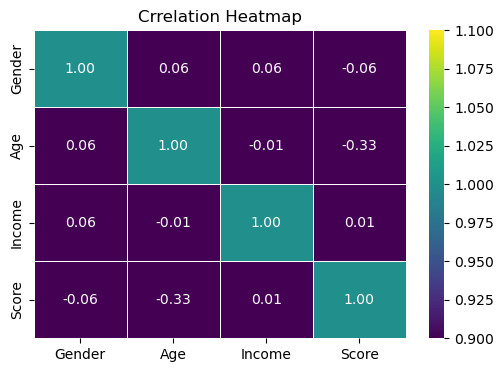

In [27]:
plt.figure(figsize=(6,4))
sns.heatmap(update_dataset.corr(),fmt=".2f",cmap="viridis",annot=True,linewidths=0.5,linecolor="white",vmin=1,vmax=1)
plt.title("Crrelation Heatmap") 

*This selects the columns "Age", "Income", and "Score" from the dataset and creates a pairplot.
A pairplot shows scatter plots for every pair of variables and histograms for individual variables, helping to visualize relationships and distributions between features.*

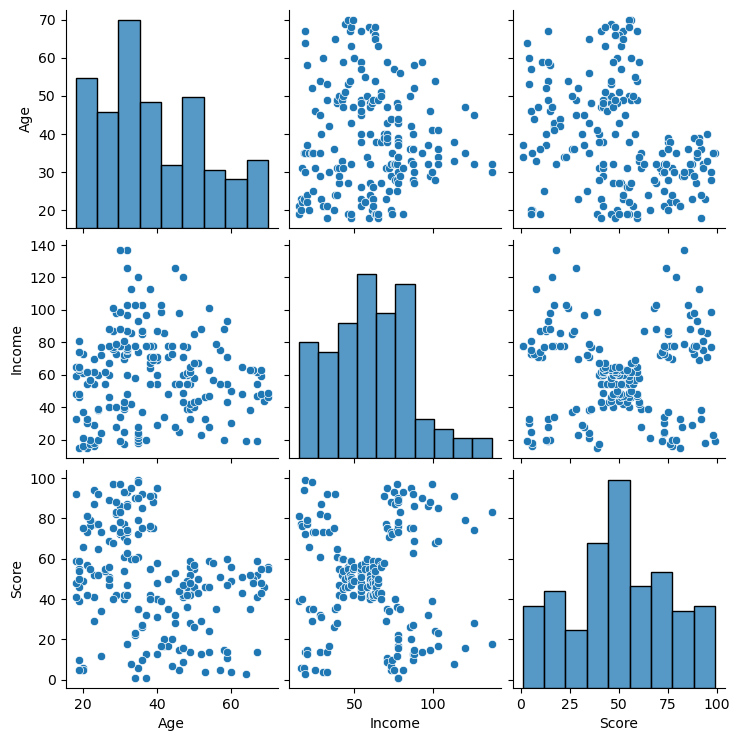

In [28]:
data =update_dataset[["Age","Income","Score"]]
sns.pairplot(data=data) 

*This loop runs KMeans clustering for 1 to 10 clusters and stores the within-cluster sum of squares (WCSS) for each to help find the optimal number of clusters.*

In [29]:
wcss =[]
K_range = range(1,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k,random_state=9)
    kmeans.fit(update_dataset[["Income","Score"]])
    wcss.append(kmeans.inertia_) 

*This code plots the WCSS values against the number of clusters to visualize the "elbow," helping identify the optimal cluster count.*

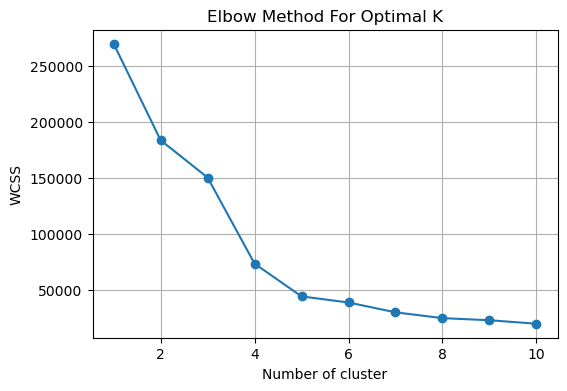

In [30]:
plt.figure(figsize=(6,4))
plt.plot(K_range,wcss,marker ="o")
plt.title("Elbow Method For Optimal K")
plt.xlabel("Number of cluster")
plt.ylabel("WCSS")
plt.grid(True)

*This uses the KneeLocator to find the “elbow point” in the WCSS curve, which indicates the optimal number of clusters for KMeans.*

In [31]:
kn =KneeLocator(K_range,wcss,curve="convex",direction="decreasing")
Optimal_k = kn.knee
print(f"Optimal Number of Cluster:{Optimal_k}")

Optimal Number of Cluster:5


*This fits the KMeans model with the optimal number of clusters and assigns each data point to a cluster. It also stores the cluster centers (centroids).*

In [32]:
kmeans = KMeans(n_clusters=Optimal_k,random_state=8)
update_dataset["Clusters"] = kmeans.fit_predict(update_dataset[["Income","Score"]])
center = kmeans.cluster_centers_ 

*This plots each clustr's data point with different colors. It adds the new customer's point in purple with a special marker. It plots cluster centroids as black stars. The function predicts which cluster a new customer belongs to based on their income and score.*

New Customer (Income: 15, Score: 39) falls in Cluster 1


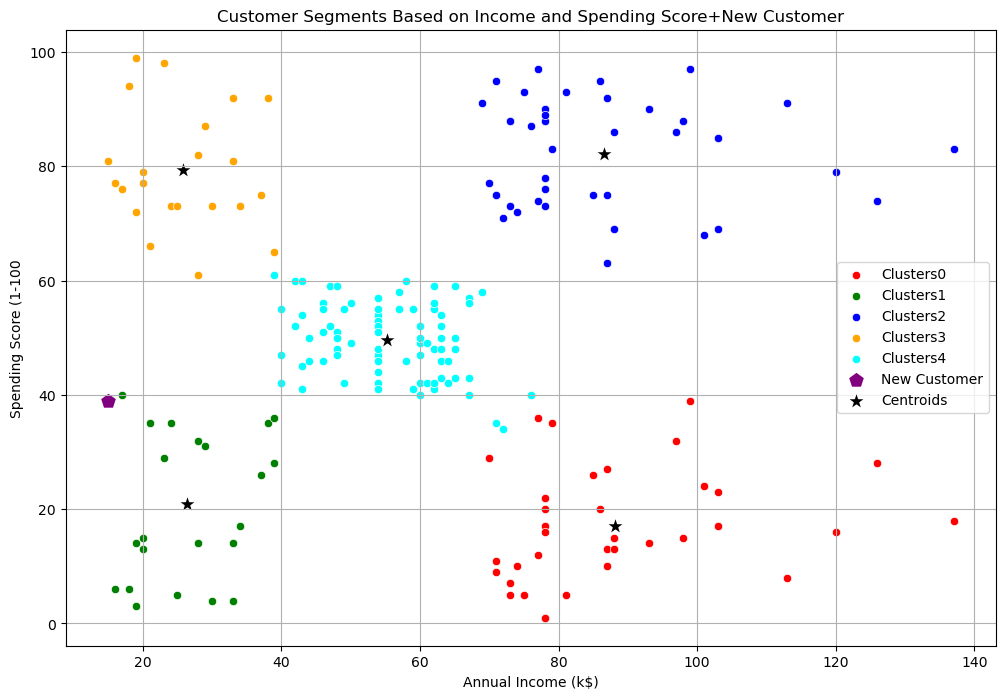

In [36]:
plt.figure(figsize=(12,8))
colors =["red","green","blue","orange","cyan"] 
for i in range(Optimal_k):
    cluster_data = update_dataset[update_dataset["Clusters"] == i]
    sns.scatterplot(x =cluster_data["Income"],y =cluster_data["Score"],label=f"Clusters{i}",color=colors[i])
    
sns.scatterplot(x=[15], y=[39],color="purple", s=150, marker="p", label="New Customer")

sns.scatterplot(x =center[:,0],y =center[:,1],marker="*",s =200,color="black",label ="Centroids")
plt.title("Customer Segments Based on Income and Spending Score+New Customer")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100")
plt.legend()
plt.grid(True)
def predict_customer_cluster(income, score):
    new_customer = np.array([[income, score]])
    cluster = kmeans.predict(new_customer)[0]
    print(f"New Customer (Income: {income}, Score: {score}) falls in Cluster {cluster}")
predict_customer_cluster(15,39)


*This prints the average values of each feature (Age, Gender, Income, Score) for every cluster, helping you understand the typical profile of customers in each group.*

In [34]:
print(update_dataset.groupby("Clusters").mean()) 

            Gender        Age     Income      Score
Clusters                                           
0         0.542857  41.114286  88.200000  17.114286
1         0.391304  45.217391  26.304348  20.913043
2         0.461538  32.692308  86.538462  82.128205
3         0.409091  25.272727  25.727273  79.363636
4         0.407407  42.716049  55.296296  49.518519


*This line saves the trained KMeans model using joblib.*

In [35]:
joblib.dump(kmeans,"kmeans_model.pkl")

['kmeans_model.pkl']